Jako model sieciu użyto modelu z artykułu https://arxiv.org/abs/2009.11212

Wyjaśnienie batch_size https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network

In [237]:
!pwd
!ls ../../../SpinakerV1Data/2023-01-19-d3-red1

/home/duckietown/DuckieSandbox/Spinakerv1/assets/jupyter
data.csv  img


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.python.keras.models import load_model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import cv2
import pandas as pd
import ntpath
import random
import tensorflow as tf

tf.random.set_seed(42)
print(keras.__version__)
print(tf.__version__)

2023-01-25 15:04:51.304345: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 15:04:51.380600: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/duckietown/DuckieSandbox/dtagh_ws/devel/lib:/home/duckietown/DuckieSandbox/duckietow_ws/devel/lib:/opt/ros/noetic/lib
2023-01-25 15:04:51.380613: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-25 15:04:51.791413: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:6

2.11.0
2.11.0


In [2]:
datadir = '../../../SpinakerV1Data/2023-01-19-d3-red1'
data = pd.read_csv(os.path.join(datadir, 'data.csv'))
pd.set_option('display.max_colwidth', None)
data.head()

,filename,v,omega
0,img/0000.png,0.4,-0.100
1,img/0001.png,0.4,-0.100
2,img/0002.png,0.4,-0.100
3,img/0003.png,0.4,-0.100
4,img/0004.png,0.4,-0.075


[-0.94999999 -0.78749998 -0.62499998 -0.46249998 -0.29999997 -0.13749997
  0.02500003  0.18750004  0.35000004  0.51250004  0.67500005  0.83750005
  1.00000005  1.16250006  1.32500006  1.48750007  1.65000007  1.81250007
  1.97500008  2.13750008  2.30000008  2.46250009  2.62500009  2.78750009
  2.9500001   3.1125001   3.2750001   3.43750011  3.60000011  3.76250012
  3.92500012  4.08750012  4.25000013  4.41250013  4.57500013  4.73750014
  4.90000014  5.06250014  5.22500015  5.38750015  5.55000015  5.71250016
  5.87500016  6.03750017  6.20000017  6.36250017  6.52500018  6.68750018
  6.85000018  7.01250019  7.17500019]
[-0.86874999 -0.70624998 -0.54374998 -0.38124998 -0.21874997 -0.05624997
  0.10625004  0.26875004  0.43125004  0.59375005  0.75625005  0.91875005
  1.08125006  1.24375006  1.40625006  1.56875007  1.73125007  1.89375007
  2.05625008  2.21875008  2.38125009  2.54375009  2.70625009  2.8687501
  3.0312501   3.1937501   3.35625011  3.51875011  3.68125011  3.84375012
  4.00625012  

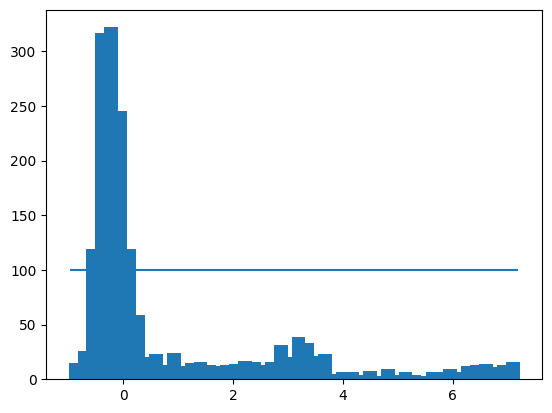

In [3]:
num_bins = 50
samples_per_bin = 100
hist, bins = np.histogram(data['omega'], num_bins)
center = (bins[:-1]+bins[1:]) * 0.5
plt.bar(center, hist, width=0.25)
plt.plot((np.min(data['omega']), np.max(data['omega'])), (samples_per_bin, samples_per_bin))
print(bins)
print(center)

total date: 1796
removed  622
remaning 1174


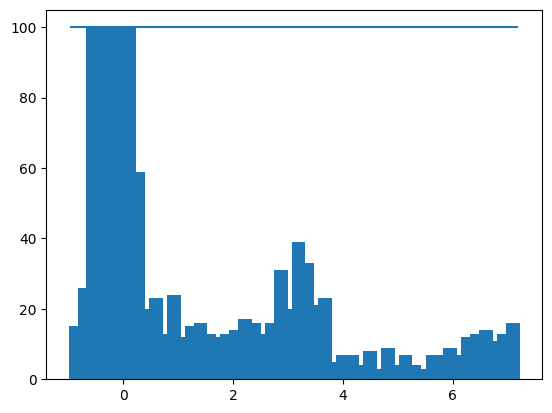

In [4]:
print('total date:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['omega'])):
    if data['omega'][i] >= bins[j] and data['omega'][i] <= bins[j+1]:
      list_.append(i) 
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed ', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaning', len(data))

hist, _ = np.histogram(data['omega'], num_bins)
plt.bar(center, hist, width=0.25)
plt.plot((np.min(data['omega']), np.max(data['omega'])), (samples_per_bin, samples_per_bin))

In [5]:
print(data.iloc[1])
def load_img_stearing(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    # Save path to image
    image_path.append(os.path.join(datadir, data.iloc[i].filename.strip()))
    # Save omega 
    steering.append(float( data.iloc[i].omega ))

  image_paths = np.array(image_path)
  steerings = np.array(steering)
  return image_paths, steerings                                           

image_paths, steerings = load_img_stearing(datadir, data)

filename    img/0005.png
v                    0.4
omega             -0.025
Name: 5, dtype: object


In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Traning Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))
print(X_train[1])
print(y_train[1])

Traning Samples: 939
Valid Samples: 235
../../../SpinakerV1Data/2023-01-19-d3-red1/img/1328.png
-0.4749999940395355


Text(0.5, 1.0, 'Validations sets')

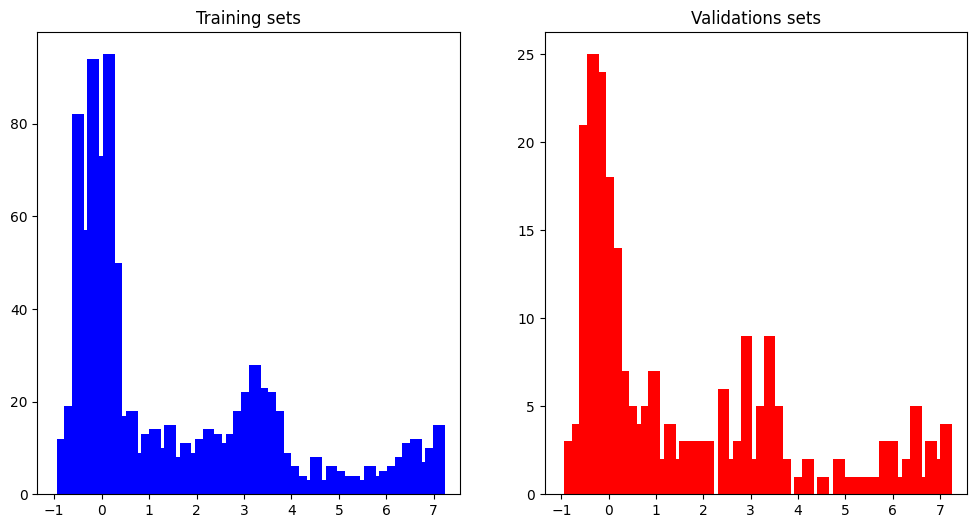

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].hist(y_train, bins=num_bins, width=0.25, color='blue')
axes[0].set_title('Training sets')
axes[1].hist(y_valid, bins=num_bins, width=0.25, color='red')
axes[1].set_title('Validations sets')

In [48]:
def img_preprocess(img):
  # img = mpimg.imread(img)
  img = cv2.imread(img)
  img = img[300:500, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (80, 60))
  # img = img/255.0
  img = (img - np.min(img)) / (np.max(img) - np.min(img))
  print("max: ", np.max(img), " min: ", np.min(img))
  return img

max:  1.0  min:  0.0


(-0.5, 79.5, 59.5, -0.5)

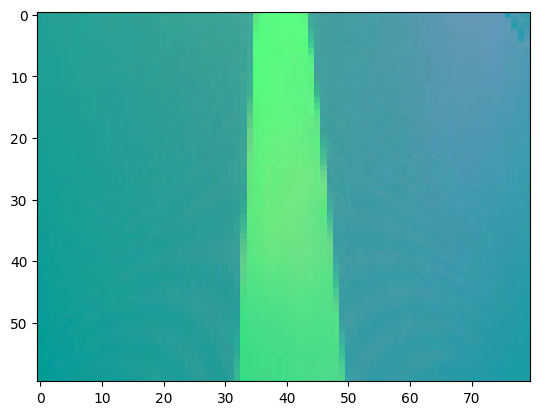

In [32]:
plt.imshow(img_preprocess(X_train[random.randint(0, len(X_train)-1)]))
plt.axis('on')

Convert X_train with image paths to image as np.array

In [33]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  min:  0.0
max:  1.0  mi

(939, 60, 80, 3)


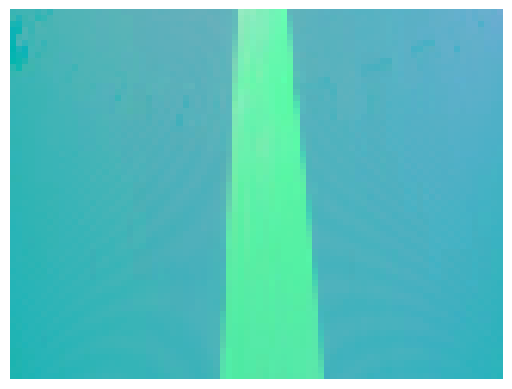

In [34]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)] )
plt.axis('off')
print(X_train.shape)

In [35]:
def nvidia_model():
 
  model = Sequential()
 
  model.add(Conv2D(32, kernel_size=(3,3), input_shape=(60,80,3),activation='relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
  model.add(MaxPool2D((2,2)))
  
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(64, activation='tanh'))
  model.add(Dropout(0.25))
  model.add(Dense(1))
 
  optimizer= Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
 
  return model

In [36]:
model=nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 78, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 39, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 37, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 18, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 16, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 8, 64)         0

2023-01-25 15:06:58.954936: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 15:06:58.955106: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/duckietown/DuckieSandbox/tensorflow/lib/python3.8/site-packages/cv2/../../lib64:/home/duckietown/DuckieSandbox/dtagh_ws/devel/lib:/home/duckietown/DuckieSandbox/duckietow_ws/devel/lib:/opt/ros/noetic/lib
2023-01-25 15:06:58.955154: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/duckietown/DuckieSandbox/tensorfl

In [37]:
tf.random.set_seed(42)
model=nvidia_model()
history = model.fit(X_train, y_train, 
    epochs=10, 
    validation_data=(X_valid, y_valid), 
    batch_size=50, 
    verbose=1, shuffle=1)

Epoch 1/10
19/19 [==============================] - 1s 51ms/step - loss: 4.2500 - val_loss: 1.6007
Epoch 2/10
19/19 [==============================] - 1s 47ms/step - loss: 0.9996 - val_loss: 0.4396
Epoch 3/10
19/19 [==============================] - 1s 50ms/step - loss: 0.4510 - val_loss: 0.1608
Epoch 4/10
19/19 [==============================] - 1s 47ms/step - loss: 0.2606 - val_loss: 0.1097
Epoch 5/10
19/19 [==============================] - 1s 47ms/step - loss: 0.2234 - val_loss: 0.0997
Epoch 6/10
19/19 [==============================] - 1s 47ms/step - loss: 0.1713 - val_loss: 0.0691
Epoch 7/10
19/19 [==============================] - 1s 47ms/step - loss: 0.1624 - val_loss: 0.0554
Epoch 8/10
19/19 [==============================] - 1s 47ms/step - loss: 0.1732 - val_loss: 0.0543
Epoch 9/10
19/19 [==============================] - 1s 50ms/step - loss: 0.2070 - val_loss: 0.0762
Epoch 10/10
19/19 [==============================] - 1s 46ms/step - loss: 0.1497 - val_loss: 0.0662


Text(0.5, 0, 'Epoch')

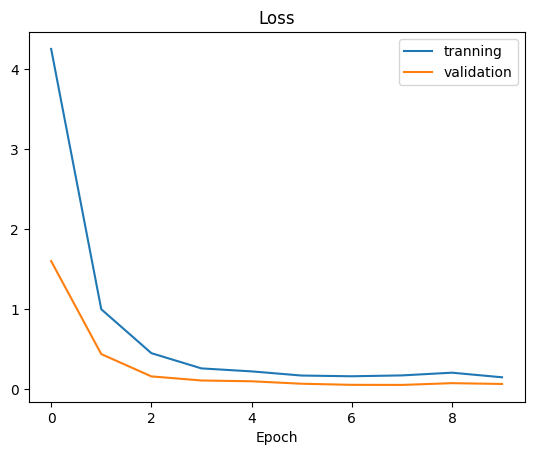

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['tranning', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

* model-2022-01-25-01.h5 - z normalizacja
* model-2022-01-25-02.h5 - bez normalizacji 

In [39]:
nn_model_path = '../nn_models/'
nn_model_name = 'model-2022-01-25-01-cv2.h5'
model.save(nn_model_path + nn_model_name)

# Walidacja modelu

In [40]:
model2 = load_model(nn_model_path + nn_model_name)
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 58, 78, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 29, 39, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 18, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 8, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 8, 64)         

max:  1.0  min:  0.0
img_index: 81, ../../../SpinakerV1Data/2023-01-19-d3-red1/img/0085.png => steering: 0.1500000059604644
NN model result steering: 0.17092536389827728
Difference between data and model prediction: -0.02092535793781289


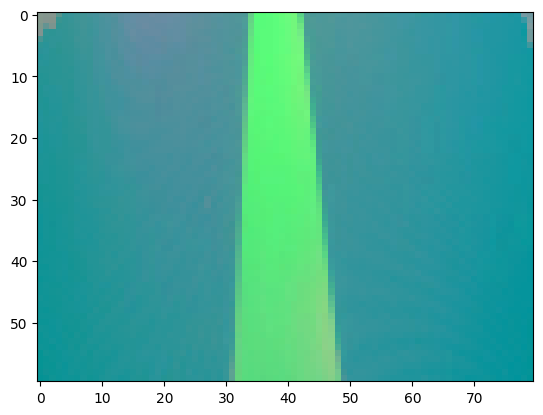

In [62]:
img_index = random.randint(0, len(X_train)-1)
prepared_image = np.array(img_preprocess(image_paths[img_index]))
plt.imshow(prepared_image, aspect="auto")
model2_result = model2.predict_on_batch( np.expand_dims(prepared_image, 0))

print("img_index: {}, {} => steering: {}".format(img_index, image_paths[img_index], steerings[img_index]) )
print("NN model result steering: {}".format(model2_result[0,0]))
print("Difference between data and model prediction: {}".format(steerings[img_index]-model2_result[0,0]))

In [63]:
model2.evaluate(X_valid, y_valid, return_dict=True)
model2.predict( np.expand_dims(prepared_image, 0), verbose=2)[0,0]

8/8 [==============================] - 0s 5ms/step - loss: 0.0662
1/1 - 0s


0.17092536

In [26]:
img_cv2 = cv2.imread(image_paths[img_index])
cv2.imshow('image',img_cv2)
cv2.waitKey(0)
cv2.destroyAllWindows()
plt.imshow(img_cv2)